In [1]:
from matminer.datasets import load_dataset
import pandas as pd
from pymatgen.ext.matproj import MPRester
from ase import Atoms
from pymatgen.io.ase import AseAtomsAdaptor
from dscribe.descriptors import SOAP
import numpy as np
import re
import pickle
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


## Band Gap energy
Load in the dft and experimental data. Convert dft compositional data to formula to match the experimental formula.

In [2]:
# load experimental data
df_exp = load_dataset('expt_gap_kingsbury')
df_exp = df_exp.dropna(subset=['likely_mpid'])
print(df_exp.shape)
display(df_exp.head())

# load DFT data
df_dft = load_dataset('jarvis_dft_3d')
df_dft = df_dft.drop(columns=['epsilon_x opt', 'epsilon_y opt', 'epsilon_z opt', 'shear modulus', 'bulk modulus', 'jid', 'epsilon_x tbmbj', 'epsilon_y tbmbj', 'epsilon_z tbmbj'])
df_dft['formula'] = df_dft['composition'].apply(lambda x: x.reduced_formula) # convert composition to formula
df_dft = df_dft.dropna()
print(df_dft.shape)
display(df_dft.head())

(2481, 3)


,likely_mpid,expt_gap,formula
1,mp-29717,0.00,Ag(W3Br7)2
5,mp-23558,0.00,Ag2BiO3
6,mp-9900,1.98,Ag2GeS3
8,mp-23485,2.47,Ag2HgI4
9,mp-1203404,3.06,Ag2Mo(I2O7)2


/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/pymatgen/core/periodic_table.py:289: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


(7349, 8)


,structure,e_form,structure initial,gap tbmbj,mpid,gap opt,composition,formula
59,"[[ 8.9342299 3.79961599 -6.97400918] Mg, [ 3...",-2.896,"[[ 8.9825888 3.8061472 -7.01147537] Mg, [ 3...",7.8043,mp-6596,5.2711,"(Mg, Al, P, O)",MgAlPO5
68,"[[1.25762093 4.13616104 2.44785671] K, [3.7426...",-2.657,"[[1.26002845 4.20573168 2.5197491 ] K, [3.7544...",8.3622,mp-7324,5.6141,"(K, Be, P, O)",KBePO4
75,"[[3.1506963 4.30596127 3.56982179] As, [0.384...",0.025,"[[3.17888147 4.36479751 3.69558323] As, [0.381...",0.6495,mp-158,0.0221,(As),As
80,"[[0.37213617 3.67987527 0.87369073] H, [1.4889...",-1.184,"[[0.34436223 3.69323659 0.87470146] H, [1.4990...",0.0083,mp-24242,0.0038,"(H, O, F, Cu)",CuHOF
83,"[[ 0.92796672 1.82915421 10.16747299] O, [2.7...",-2.086,"[[ 0.938753 1.84002706 10.93783201] O, [2.8...",2.4642,mp-510584,1.9202,"(O, Mo)",MoO3


Create a dataframe of dft data for MP-ID's that are in both the experimental and dft datasets.

In [3]:
df_dft_filtered = df_dft[df_dft['mpid'].isin(df_exp['likely_mpid'])].reset_index(drop=True)
print(df_dft_filtered.shape)

(329, 8)


## Extract the total number of species in the dataset
This is necessary because our vector size for the algorithm must be the same shape. This ensures that the SOAP vector (see below) is of equal shape. Will will feed in all the species in a dataset. This will generate a lot of entries that are zero. This should be good for ML since its an additional source of information.

In [3]:
species_regex = r'[A-Z][a-z]*'  # Matches capital letter followed by lowercase letters

# Function to extract species from a single formula
def extract_species(formula):
    return set(re.findall(species_regex, formula))

# Function to extract species from a formula
def extract_species_from_df_column(df_column):
    # Apply the function to the dataframe column and get species
    all_species = set()
    species = df_column.apply(extract_species)
    # Collect all species into a single set
    for species_list in species:
        all_species.update(species_list)
    return list(all_species)

dft_unique_species = extract_species_from_df_column(df_dft['formula'])
print('Unique species in DFT data:', dft_unique_species)

exp_unique_species = extract_species_from_df_column(df_exp['formula'])
print('Unique species in experimental data:', exp_unique_species)

mpids = df_dft['mpid'].tolist() # list of mpids
print(mpids[0:5])

Unique species in DFT data: ['Mg', 'Sn', 'Sc', 'U', 'Re', 'As', 'P', 'Au', 'He', 'In', 'Ni', 'Ge', 'Ga', 'Th', 'Rb', 'Ce', 'Ar', 'Br', 'C', 'Tm', 'Er', 'Te', 'I', 'Mn', 'Fe', 'H', 'Se', 'Ho', 'Dy', 'La', 'Y', 'Na', 'Ca', 'F', 'Ru', 'Li', 'Tc', 'W', 'Al', 'Hg', 'Yb', 'Sb', 'Cs', 'Pb', 'S', 'Sm', 'Pd', 'Pt', 'Tb', 'K', 'Co', 'Rh', 'Pr', 'Os', 'Ti', 'Hf', 'Cd', 'Si', 'Ba', 'Ne', 'Lu', 'Tl', 'B', 'Ta', 'V', 'Cr', 'O', 'Be', 'Mo', 'Ir', 'Cu', 'Zn', 'Sr', 'Ag', 'Nb', 'Cl', 'Zr', 'Nd', 'Pa', 'Bi', 'Kr', 'N']
Unique species in experimental data: ['Mg', 'Sn', 'Sc', 'U', 'Re', 'As', 'P', 'Au', 'In', 'Ni', 'Ge', 'Ga', 'Th', 'Rb', 'Ce', 'Br', 'C', 'Tm', 'Er', 'Te', 'Fe', 'I', 'Mn', 'Se', 'H', 'Ho', 'Dy', 'La', 'Na', 'Y', 'Ca', 'Ru', 'F', 'Li', 'Gd', 'Tc', 'W', 'Hg', 'Al', 'Yb', 'Sb', 'Cs', 'S', 'Pb', 'Sm', 'Pd', 'Tb', 'Pt', 'Co', 'K', 'Rh', 'Pr', 'Os', 'Ti', 'Hf', 'Cd', 'Si', 'Xe', 'Ba', 'Lu', 'Tl', 'B', 'Ta', 'V', 'Cr', 'Eu', 'O', 'Mo', 'Ir', 'Be', 'Cu', 'Zn', 'Sr', 'Ag', 'Nb', 'Cl', 'Zr', 'Nd', 

## Generate the SOAP descriptor

The **SOAP (Smooth Overlap of Atomic Positions)** descriptor is a powerful tool used in computational materials science to represent the local atomic environment of a material. It encodes information about the local symmetry and structure of atoms in a material, making it suitable for use in machine learning models that predict material properties.

### Key Features:
- **Local Environment Representation**: The SOAP descriptor captures the atomic environment around each atom in a structure, using a smooth overlap of atomic positions.
- **Spherical Harmonics**: The descriptor uses spherical harmonics to represent angular information, allowing it to effectively capture local symmetries.
- **Radial Basis Functions**: The radial part of the descriptor is represented using radial basis functions, which help model the distances between atoms.
- **Species Specific**: The descriptor can incorporate the chemical species present in the structure, allowing it to adapt to different materials.

### How It Works:
1. **Structure Representation**: The local atomic environment of each atom is represented by a combination of radial and angular functions.
2. **Cutoff Radius**: Only atoms within a certain cutoff radius contribute to the descriptor, ensuring computational efficiency.
3. **Smearing**: Gaussian smearing is used to smooth the atomic positions, ensuring a continuous representation.
4. **Periodic Structures**: SOAP can be used to model periodic structures such as crystals, making it suitable for large-scale materials simulations.


In [4]:
API_KEYcm = "cmeSCicjBiIc0Nk02lArDwjO4V0jyXKw"

def generate_soap_descriptor(mp_id, API_KEY=API_KEYcm):
    # 1. Connect to Materials Project
    mpr = MPRester(API_KEY)
    
    # 2. Fetch structure by MP-ID
    structure_pmg = mpr.get_structure_by_material_id(mp_id)

    # 3. Convert pymatgen structure to ASE Atoms
    ase_structure = AseAtomsAdaptor.get_atoms(structure_pmg)

    # 4. Check if species from provided list matches with the structure
    structure_species = list(set(ase_structure.get_chemical_symbols()))  # Unique elements in the structure
    
    # 5. Set up SOAP descriptor
    soap = SOAP(
        species=structure_species,   # List of elements present (user-specified)
        periodic=True,          # Is the structure periodic? (crystals = True, molecules = False)
        r_cut=5.0,              # Cutoff radius (Å)
        n_max=8,                # Number of radial basis functions
        l_max=6,                # Maximum degree of spherical harmonics
        sigma=0.5,              # Width (smearing) of Gaussians placed on atoms (Å)
        sparse=False            # Should output be dense NumPy array? (False = full array; True = sparse matrix for memory saving)
    )

    # 6. Create SOAP descriptors
    soap_descriptors = soap.create(ase_structure)

    return soap_descriptors

# Example usage
# soap_descriptor = generate_soap_descriptor(mp_id=mpids[0])

# print(soap_descriptor.shape)



## Calculate Soap Descriptors
Below code generates soap descriptors for all mpids in the df_dft dataset and creates a dataframe

In [5]:
# Generate SOAP descriptors for all mpids
soap_dict = {}
for i, mpid in enumerate(mpids):
    try:
        soap_descriptor = generate_soap_descriptor(mp_id=mpid)
        soap_dict[df_dft['formula'].iloc[i]] = soap_descriptor
        soap_dict[df_dft['mpid'].iloc[i]] = soap_descriptor
    except Exception as e:
        print(f"Skipping {mpid} due to error: {e}")


df_soap = pd.DataFrame({
    'formula': soap_dict.keys(),
    'soap_descriptor': soap_dict.values()
})
df_soap = df_soap.merge(df_dft[['formula', 'mpid']], on='formula', how='left')
df_soap.drop_duplicates(subset=['formula'], inplace=True)
df_soap.dropna(inplace=True)
df_soap.reset_index(drop=True, inplace=True)
print(df_soap.shape)
save_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/soap_descriptors_raw.pkl.gz'
# # Save as compressed pickle
# with gzip.open(save_path, 'wb') as f:
#     pickle.dump(df_soap, f)

/Users/cadenmyers/miniconda3/envs/ml4ms/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-510584 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-714976 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5440.08it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-510733 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565784 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867695 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13245 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6946 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-556520 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-540570 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-558761 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561238 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-578614 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764673 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867168 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867192 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867194 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-12992 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-13147 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 23172.95it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10016 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11052 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11360 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11564 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11600 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11686 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11768 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12823 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12841 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12939 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13426 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13442 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13450 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13470 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13472 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13496 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13497 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13729 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13836 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13902 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13958 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14178 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14678 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14725 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14755 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14834 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14925 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15370 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15384 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15694 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15700 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15785 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15886 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15946 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16068 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16070 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16073 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16081 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16090 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

Skipping mvc-16091 due to error: 'list' object has no attribute 'is_ordered'



Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16811 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3451 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3515 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3524 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5676 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7051 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 22671.91it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-24927 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-24964 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25119 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-34134 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5991.86it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-559198 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-559249 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2428.66it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-559327 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-557458 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-557483 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-555480 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-555936 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5127.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-556134 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14217.98it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-510666 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-10838 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10082.46it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25558 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-31725 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-715324 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-976058 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-blackP due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-icsd-14390 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-icsd-152836 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-icsd-603582 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-icsd-626718 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-icsd-651404 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1216 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6615.62it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25118 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-286 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-32479 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25475 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3368.92it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1001570 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1007866 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4568.96it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1136 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1621 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1623 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1657 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1659 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1666 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2085 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2157 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2186 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2430 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2447 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2453 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2851 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2854 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2858 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2876 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-446 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-921 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11491.24it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2955 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3091 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3265 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3283 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3380 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3477 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3853 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4245 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13530.01it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4609 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4658 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4662 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4668 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4676 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4703 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4706 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4822 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4955 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5170 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5272 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5448 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5517 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5559 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5788 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5865 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5884 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5997 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6066 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6071 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6083 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6101 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6159 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6402 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6403 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6495 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6512 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6547 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6554 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6570 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6590 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6910 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6933 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-7028 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14979.66it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7276 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7295 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7302 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7315 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7347 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8202 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8472 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8773 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8797 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10006 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-9991 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10706 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10720 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11093 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11115 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11131 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11560 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11647 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11739 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11848 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11912 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15827.56it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12347 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12368 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12404 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12553 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12576 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12619 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13972 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14054 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14195 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14224 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14225 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14231 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14279 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14293 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14411 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14586 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14589 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14876 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14941 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15178 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15566 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15601 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15812 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15814 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15941 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15991 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16060 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16094 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16230 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16271 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16274 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16291 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16497 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-24854 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-24868 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-24939 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25113 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25122 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25142 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25582 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7055 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-7058 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-10626 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10862 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11196 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11233 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11234 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-11241 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12866 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13105 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13133 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-15787 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-14991 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15603 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15707 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16067 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16079 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25174 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25489 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25499 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25592 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 10645.44it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1668 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-866267 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-31584 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-31645 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11522.81it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-22399 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2362 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2377 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3226 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3616 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3874 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3959 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3987 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4204 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4766.25it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4926 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4931 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5007 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5130 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16644.06it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5693 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6069.90it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-782680 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15196.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5533 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765254 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771797 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626369 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626577 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626582 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626586 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 21620.12it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626876 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626878 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-632394 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-639402 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6502.80it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-640807 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-643108 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-643246 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-645218 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-645246 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-654956 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-608156 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-613172 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-614383 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-616019 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-619456 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-621182 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14665.40it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625052 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625370 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625414 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625416 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16384.00it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625600 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625678 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625751 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625784 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625917 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 11155.06it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-32541 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-780642 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-780645 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2559.06it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-780746 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-780806 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-780810 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-780818 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2839.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-849536 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5178.15it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-849586 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-850117 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-850235 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-850518 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-851028 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-853160 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-853161 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-853167 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-774289 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 9532.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-775036 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-775241 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4364.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-775983 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5440.08it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776092 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776185 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776495 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776513 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776563 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776649 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2951.66it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776836 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777096 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777150 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777239 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777432 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777629 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-778023 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-778644 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-778746 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-778928 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5777.28it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779235 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779237 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779941 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

Skipping mp-779943 due to error: 'list' object has no attribute 'is_ordered'



Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779950 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779951 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779970 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779999 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-772369 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-772592 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4080.06it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-772696 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773220 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3172.70it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773240 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773245 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773257 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773285 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773338 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773377 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773535 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773543 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773565 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770603 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770991 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771471 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771535 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771594 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771605 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771609 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771613 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767686 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767944 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767954 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-768014 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6482.70it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-769765 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-769784 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-769930 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770001 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770002 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770029 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770149 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-770150 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767161 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767197 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767226 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767228 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767239 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767283 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767313 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-767330 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 1769.00it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765518 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765545 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765813 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765849 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-766949 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-766951 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Skipping WSe2 due to error: WSe2 is not formatted correctly!


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3446.43it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-546877 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-549166 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5405.03it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-551601 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-554831 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-555491 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4419.71it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1019536 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1025262 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-1025316 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-978857 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-980083 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-980386 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-977395 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-865782 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-866836 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867133 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867203 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3905.31it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867261 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867268 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867286 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3106.89it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867322 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867328 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867334 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867335 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867340 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5526.09it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867699 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867725 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867745 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867757 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867884 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867930 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867933 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-868128 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-868168 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-868352 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-868647 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-864603 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 801.97it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-864801 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13511 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-16098 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2537.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-543096 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-555153 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 12052.60it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-555902 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561779 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5652.70it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565932 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566304 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-567019 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16131.94it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625056 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-625953 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626881 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-626902 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14315.03it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-705538 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-714873 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-715160 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]

Skipping mp-715463 due to error: 'list' object has no attribute 'is_ordered'



Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14926.35it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-715480 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-743618 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764219 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764228 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764243 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764258 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764283 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764303 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764309 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764315 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764365 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765237 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765906 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771380 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771458 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-771662 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-772598 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-773303 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-775117 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-775464 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-776707 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777080 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-777100 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4002.20it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-778781 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-779966 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-849597 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-849598 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-849702 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-853132 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-863878 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7810.62it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867724 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10067 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10084 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-13239 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-15486 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2968 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-3506 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-479 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-5746 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-668 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-678 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6826 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8162 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8418 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-8898 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-505208 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-543072 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566054 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25062 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25607 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-505000 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561708 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-623958 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-743614 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867231 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867247 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867355 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867875 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867891 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-867893 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]


Skipping Ben-100332 due to error: Ben-100332 is not formatted correctly!
Skipping Ben-1004 due to error: Ben-1004 is not formatted correctly!
Skipping Ben-100681 due to error: Ben-100681 is not formatted correctly!
Skipping Ben-1081 due to error: Ben-1081 is not formatted correctly!
Skipping Ben-10 due to error: Ben-10 is not formatted correctly!
Skipping Ben-1255 due to error: Ben-1255 is not formatted correctly!
Skipping Ben-139 due to error: Ben-139 is not formatted correctly!
Skipping Ben-16224 due to error: Ben-16224 is not formatted correctly!
Skipping Ben-184 due to error: Ben-184 is not formatted correctly!
Skipping Ben-255 due to error: Ben-255 is not formatted correctly!
Skipping Ben-2620 due to error: Ben-2620 is not formatted correctly!
Skipping Ben-3012 due to error: Ben-3012 is not formatted correctly!
Skipping Ben-3016 due to error: Ben-3016 is not formatted correctly!
Skipping Ben-3069 due to error: Ben-3069 is not formatted correctly!
Skipping Ben-3134 due to error: Be

Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 5159.05it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763061 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15887.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763341 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763356 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763357 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763386 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763671 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763786 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763946 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-763970 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 6335.81it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764218 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764221 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764231 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764232 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764277 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764285 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764287 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764292 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764305 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764339 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764366 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764398 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764407 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764818 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-764954 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765049 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-765135 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-754988 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-755213 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-758068 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2164.24it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-754225 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 22192.08it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-741706 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-743731 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 7810.62it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-752484 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-684602 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-690475 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4733.98it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-690635 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-699343 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-703260 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4860.14it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-714880 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16844.59it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-672705 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-675568 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-569317 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566321 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566337 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566404 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566459 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566504 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566537 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566698 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566749 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 4346.43it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566869 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566886 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566907 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566952 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566999 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-567084 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-567141 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 13934.56it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-567167 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3876.44it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-567447 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-19582 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-19707 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561038 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561501 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15650.39it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561804 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561825 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561826 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561909 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-561913 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14768.68it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-562207 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565303 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565394 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565425 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565574 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565666 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565693 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565714 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565801 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565823 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565846 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565854 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565879 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-565893 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-566025 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-559146 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-559479 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-559741 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-560185 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-1875 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-2146 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4630 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-4660 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-477 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 3949.44it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-10896 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-12415 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6405 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mvc-6414 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 15363.75it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-19249 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-31918 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-775075 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-25643 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-31621 due to error: 'list' object has no attribute 'is_ordered'


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 2565.32it/s]
Retrieving MaterialsDoc documents: 0it [00:00, ?it/s]


Skipping mp-782689 due to error: 'list' object has no attribute 'is_ordered'
Skipping auid-01b8499b8bba44df due to error: auid-01b8499b8bba44df is not formatted correctly!
Skipping auid-0259d68674b800c3 due to error: auid-0259d68674b800c3 is not formatted correctly!
Skipping auid-0361058f418da352 due to error: auid-0361058f418da352 is not formatted correctly!
Skipping auid-118e55383622ad35 due to error: auid-118e55383622ad35 is not formatted correctly!
Skipping auid-12f587b708c648f0 due to error: auid-12f587b708c648f0 is not formatted correctly!
Skipping auid-134f09989090f022 due to error: auid-134f09989090f022 is not formatted correctly!
Skipping auid-161a646146669ff6 due to error: auid-161a646146669ff6 is not formatted correctly!
Skipping auid-18c521390914a2e9 due to error: auid-18c521390914a2e9 is not formatted correctly!
Skipping auid-29b96b91e46e74a5 due to error: auid-29b96b91e46e74a5 is not formatted correctly!
Skipping auid-2bf2603e574aa6bf due to error: auid-2bf2603e574aa6bf i

In [17]:
df_soap.head(10)
df_dft_dedup = df_dft.drop_duplicates(subset='formula', keep='first')
df_soap_raw = df_soap.merge(df_dft_dedup[['formula', 'gap opt']], on='formula', how='left')
print(df_soap_raw.shape)
df_soap_raw.head(10)


(5358, 4)


,formula,soap_descriptor,mpid,gap opt
0,MgAlPO5,"[[7.834700877986906e-05, -0.000248821014237357...",mp-6596,5.2711
1,KBePO4,"[[1.224395792223083e-07, -5.548160208843811e-0...",mp-7324,5.6141
2,As,"[[0.18087236729129627, 0.4693173276837286, 0.5...",mp-158,0.0221
3,CuHOF,"[[8.408499979827601e-07, -6.4356783799753e-06,...",mp-24242,0.0038
4,AgI,"[[0.18083827914220227, 0.4690888310062766, 0.5...",mp-567809,1.2599
5,ZrBrN,"[[1.6087614466449077e-05, -5.929285214217304e-...",mp-570157,1.8723
6,InBr3,"[[3.8849510688717664e-07, 1.0707179561579893e-...",mp-570219,2.3104
7,YI3,"[[0.18204641291148752, 0.4670436680038411, 0.5...",mp-571442,2.6760
8,AlHO2,"[[5.891756608461837e-06, -2.8729819768613437e-...",mp-625055,5.1686
9,BiOF,"[[3.730708030672268e-06, -2.0038238223605248e-...",mp-759883,2.9829


In [23]:

def pad_or_truncate_descriptor(descriptor, target_shape=(64, 800)):
    """Ensure a SOAP descriptor has the shape (64, 800) by truncating or zero-padding."""
    if descriptor is None:
        return np.zeros(target_shape)

    descriptor = np.array(descriptor)
    padded = np.zeros(target_shape)

    # Determine actual slice size
    rows = min(target_shape[0], descriptor.shape[0])
    cols = min(target_shape[1], descriptor.shape[1])

    padded[:rows, :cols] = descriptor[:rows, :cols]
    return padded

# Apply to the 'soap_descriptor' column and store in new column 'padded_soap'
# df_soap_raw['padded_soap'] = df_soap_raw['soap_descriptor'].apply(pad_or_truncate_descriptor)
# df_soap_raw.drop(columns=['soap_descriptor'], inplace=True)
print(df_soap_raw.shape)
display(df_soap_raw.head(10))

(5358, 4)


,formula,mpid,gap opt,padded_soap
0,MgAlPO5,mp-6596,5.2711,"[[7.834700877986906e-05, -0.000248821014237357..."
1,KBePO4,mp-7324,5.6141,"[[1.224395792223083e-07, -5.548160208843811e-0..."
2,As,mp-158,0.0221,"[[0.18087236729129627, 0.4693173276837286, 0.5..."
3,CuHOF,mp-24242,0.0038,"[[8.408499979827601e-07, -6.4356783799753e-06,..."
4,AgI,mp-567809,1.2599,"[[0.18083827914220227, 0.4690888310062766, 0.5..."
5,ZrBrN,mp-570157,1.8723,"[[1.6087614466449077e-05, -5.929285214217304e-..."
6,InBr3,mp-570219,2.3104,"[[3.8849510688717664e-07, 1.0707179561579893e-..."
7,YI3,mp-571442,2.6760,"[[0.18204641291148752, 0.4670436680038411, 0.5..."
8,AlHO2,mp-625055,5.1686,"[[5.891756608461837e-06, -2.8729819768613437e-..."
9,BiOF,mp-759883,2.9829,"[[3.730708030672268e-06, -2.0038238223605248e-..."


In [24]:
# # Save the padded descriptors
save_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/padded_soap_descriptors.pkl.gz'
with gzip.open(save_path, 'wb') as f:
    pickle.dump(df_soap_raw, f)

In [ ]:
def find_largest_shape_indices_and_values(soap_descriptors):
    """
    Find the indices and values of the largest x and y dimensions among SOAP descriptors.

    Parameters:
    soap_descriptors (list or pd.Series): List of numpy arrays representing SOAP descriptors.

    Returns:
    tuple: (index_max_x, max_x, index_max_y, max_y)
    """
    max_x = 0
    max_y = 0
    index_max_x = -1
    index_max_y = -1

    for i, desc in enumerate(soap_descriptors):
        if desc is not None and len(desc.shape) >= 2:
            x, y = desc.shape
            if x > max_x:
                max_x = x
                index_max_x = i
            if y > max_y:
                max_y = y
                index_max_y = i

    return index_max_x, max_x, index_max_y, max_y


index_max_x, max_x, index_max_y, _ = find_largest_shape_indices_and_values(df_soap['soap_descriptor'])



def zero_pad_soap_descriptors(soap_descriptors, target_shape):
    """
    Zero-pad each SOAP descriptor to the target shape.

    Parameters:
    soap_descriptors (list or pd.Series): List of numpy arrays representing SOAP descriptors.
    target_shape (tuple): (target_x, target_y) shape to pad to.

    Returns:
    list: List of zero-padded numpy arrays.
    """
    padded_descriptors = []

    for desc in soap_descriptors:
        if desc is None:
            padded = np.zeros(target_shape)
        else:
            padded = np.zeros(target_shape)
            x_size = min(desc.shape[0], target_shape[0])
            y_size = min(desc.shape[1], target_shape[1]) if len(desc.shape) > 1 else 1

            # Copy data into padded array
            if len(desc.shape) == 1:
                padded[:x_size, 0] = desc[:x_size]
            else:
                padded[:x_size, :y_size] = desc[:x_size, :y_size]

        padded_descriptors.append(padded)

    return padded_descriptors

# limit `max_y`to 800 because not much info pasted 800
# max_y = 800
# print(max_x, max_y)
# padded_descriptors = zero_pad_soap_descriptors(df_soap['soap_descriptor'], (max_x, max_y))

64 800


In [3]:
import pickle
import gzip

soap_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/padded_soap_descriptors.pkl.gz'
# Step 1: Read the compressed pickle
with gzip.open(soap_path, 'rb') as f:
    padded_df = pickle.load(f)

padded_df.head()

,formula,mpid,padded_soap,gap opt
0,MgAlPO5,mp-6596,"[[7.834700877986906e-05, -0.000248821014237357...",5.2711
1,KBePO4,mp-7324,"[[1.224395792223083e-07, -5.548160208843811e-0...",5.6141
2,As,mp-158,"[[0.18087236729129627, 0.4693173276837286, 0.5...",0.0221
3,As,mp-158,"[[0.18087236729129627, 0.4693173276837286, 0.5...",0.0062
4,CuHOF,mp-24242,"[[8.408499979827601e-07, -6.4356783799753e-06,...",0.0038


In [ ]:
# soap_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/soap_descriptors.pkl.gz'

# # Step 1: Read the compressed pickle
# with gzip.open(soap_path, 'rb') as f:
#     padded_df = pickle.load(f)

# padded_df.head(5)
# df_w_bg = df_soap.merge(
#     padded_df[['formula', 'gap opt']],  # select only the necessary columns
#     on='formula',
#     how='left'  # keep all rows from df_soap
# )
# save_path = '/Users/cadenmyers/billingelab/dev/ml4ms_bandgap_final/data/padded_soap_descriptors.pkl.gz'
# with gzip.open(save_path, 'wb') as f:
#     pickle.dump(df_w_bg, f)

# df_w_bg.head()

In [27]:
# soap_df = padded_df.dropna()
# soap_df_subset = soap_df.head(30)

# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# X = np.array(soap_df_subset['flattened_soap'].tolist())
# y = np.array(soap_df_subset['gap opt'].tolist())

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("train score:", rf.score(X_train, y_train))
# print("test score:", rf.score(X_test, y_test))
# print(f"Mean Squared Error: {mse}")
# print(f"R^2 Score: {r2}")

## XGBoost

In [3]:

# Prepare data
soap_df = padded_df.dropna()
soap_df_subset = soap_df.head(100)

X = np.array(soap_df['flattened_soap'].tolist())
y = np.array(soap_df['gap opt'].tolist())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("train score:", xgb_model.score(X_train, y_train))
print("test score:", xgb_model.score(X_test, y_test))
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


: 

[2.13251833 3.25399577 2.94683353 3.0273334  3.20346617 3.39028348
 2.69674467 1.86542158 2.91727507 3.38771775 3.71134065 1.45697975
 2.27765842 2.61406473 4.75713305 3.35240686 2.12542003 2.63983613
 2.76873132 1.86542158]


Text(0, 0.5, '$y_{test} (eV)$')

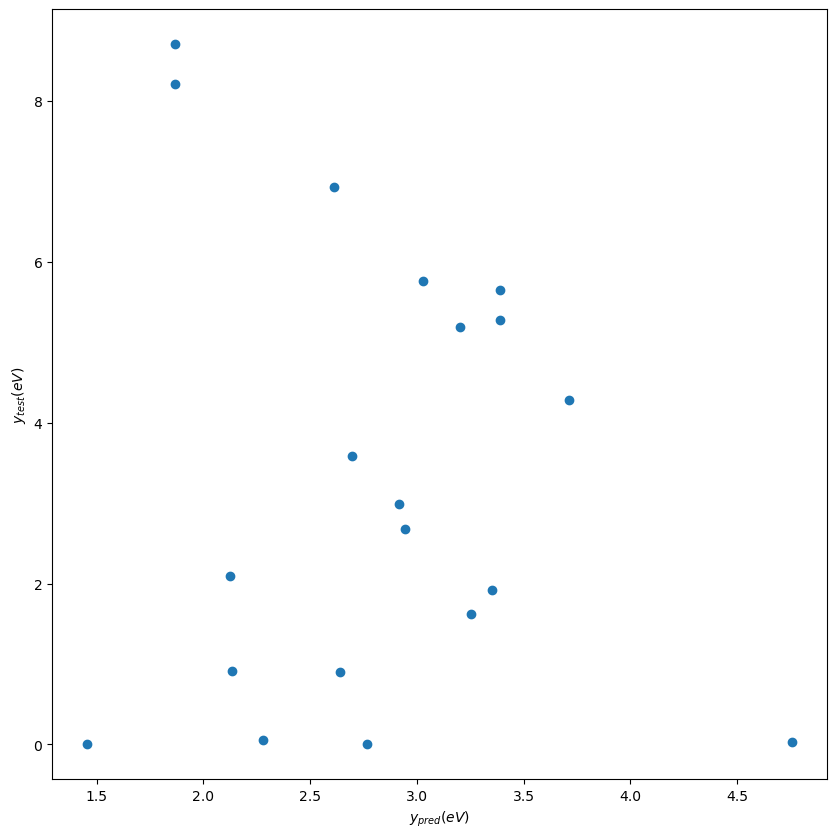

In [27]:
import matplotlib.pyplot as plt

print(y_pred)
plt.figure(figsize=(10, 10))
plt.scatter(y_pred, y_test)
plt.xlabel('$y_{pred} (eV)$')
plt.ylabel('$y_{test} (eV)$')